In [1]:
from typing import Set, Callable

from Ballot import Ballot
from CandidateModel import CandidateModel
from DefaultConfigOptions import *
from Election import Election
from ElectionResult import ElectionResult
from HeadToHeadElection import HeadToHeadElection
from InstantRunoffElection import InstantRunoffElection
from NDPopulation import NDPopulation
import pickle
from ModelStats import ModelStats
from ProcessResult import ProcessResult

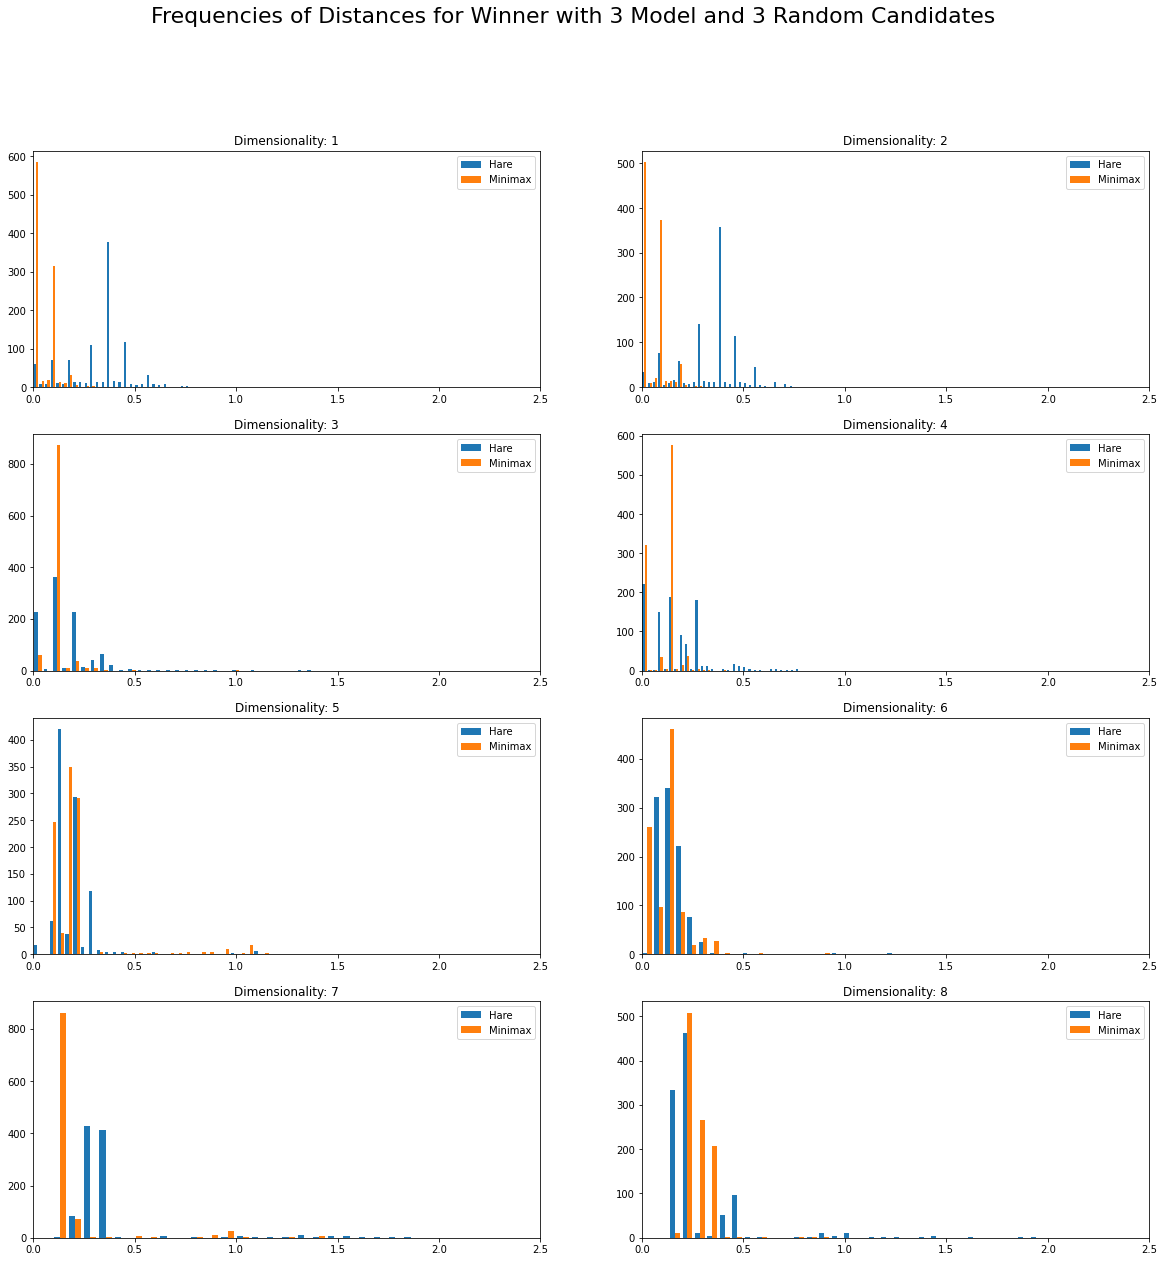

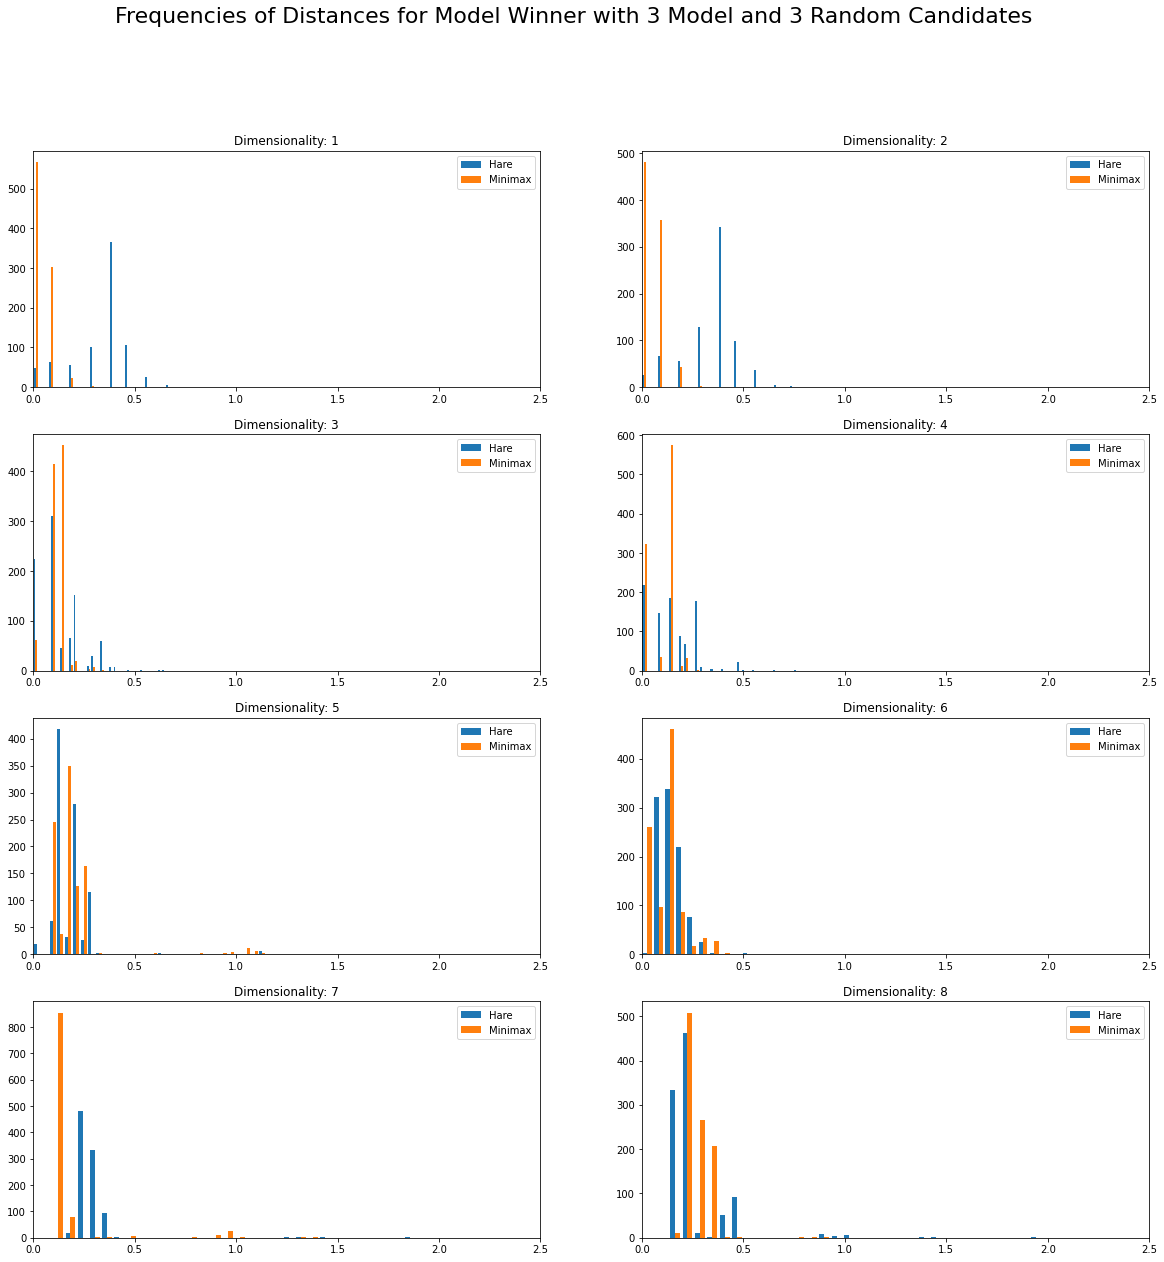

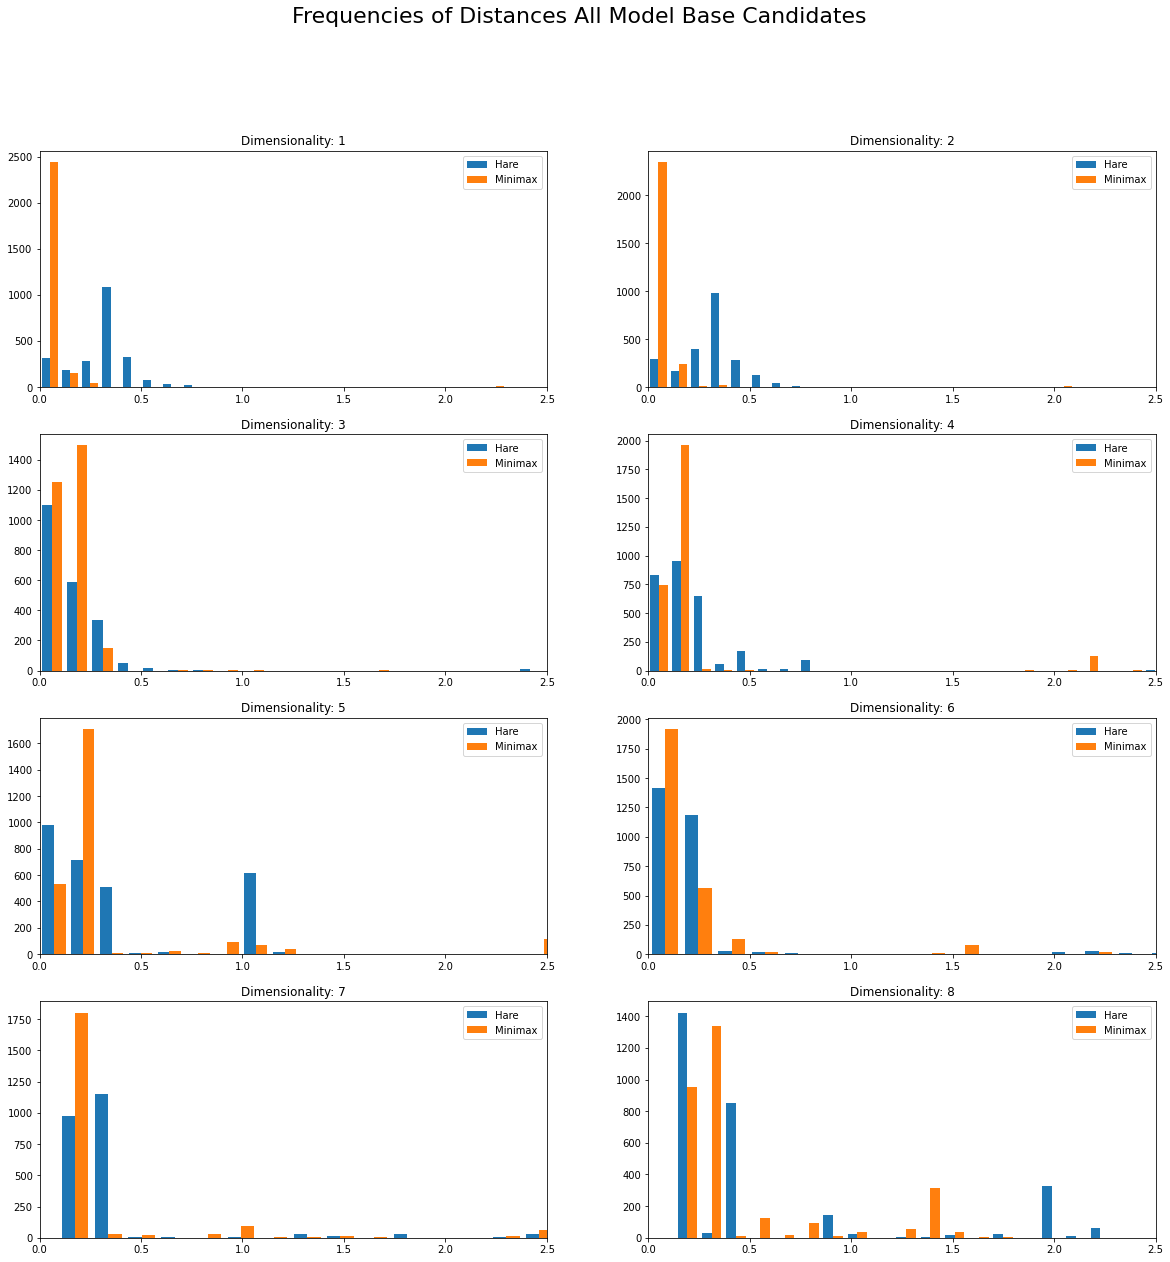

In [4]:
import glob
import matplotlib.pyplot as plt
import numpy as np

def load_path(path: str) -> any:
    with open(path, "rb") as f:
        return pickle.load(f)

def plot_results(irv_results: List[List[Candidate]], h2h_results: List[List[Candidate]], title: str):
    nrows = len(irv_results) // 2
    fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(20,20))
    fig.suptitle(title, color="black", fontsize=22)
    fig.set_facecolor("white")
    count = 0
    for ir, hr in zip(irv_results, h2h_results):
        row = count // 2
        col = count % 2
        count += 1

        axis = axes[row][col]
        axis.tick_params(axis='x', colors="black")
        axis.tick_params(axis='y', colors="black")
        axis.set_xlim([0, 2.5])

        iv = [ c.ideology.distance_from_o() for c in ir]
        hv = [ c.ideology.distance_from_o() for c in hr]

        axis.hist([iv, hv], bins=30, label=["Hare", "Minimax"])
        axis.set_title("Dimensionality: %d" % count, color="black")

        axis.legend()


def filter_results(pr: ProcessResult) -> ProcessResult :
    rr = [r for r in pr.stats.results if r[0].name[0] == 'm']
    ms = ModelStats()
    for r in rr:
        ms.update(r[0], r[1])
    return ProcessResult(pr.process, pr.bins, pr.dim, ms)

def make_plots():

    count = 0
    # irv_results = [r for r in results if r.process.name == "Instant Runoff"]
    # h2h_results = [r for r in results if r.process.name == "Head-to-Head"]

    irv_results: List[ProcessResult] = [load_path(s) for s in glob.glob("saved_results/Hare*.p")]
    h2h_results: List[ProcessResult] = [load_path(s) for s in glob.glob("saved_results/Minimax*.p")]

    irv_results.sort(key=lambda x: x.dim)
    h2h_results.sort(key=lambda x: x.dim)

    def winners(results: ProcessResult) -> List[Candidate]:
        return [w for w, cc in results.stats.results]

    def get_candidates(results: ProcessResult) -> List[Candidate]:
        candidates: List[Candidate] = []
        for w, cc in results.stats.results:
            mc = [c for c in cc if c.name[0] == 'm']
            candidates  += mc
        return candidates

    plot_results(
        [winners(ir) for ir in irv_results],
        [winners(hr) for hr in h2h_results],
        "Frequencies of Distances for Winner with 3 Model and 3 Random Candidates")

    filtered_irv = [filter_results(ir) for ir in irv_results]
    filtered_h2h = [filter_results(hr) for hr in h2h_results]

    plot_results(
        [winners(ir) for ir in filtered_irv],
        [winners(hr) for hr in filtered_h2h],
        "Frequencies of Distances for Model Winner with 3 Model and 3 Random Candidates")

    plot_results(
        [get_candidates(ir) for ir in filtered_irv],
        [get_candidates(hr) for hr in filtered_h2h],
        "Frequencies of Distances All Model Base Candidates")

make_plots()